### **기본 설정**

- 필수 모듈 불러오기
- 그래프 출력 관련 기본 설정 지정

In [ ]:
pip install mglearn

     |████████████████████████████████| 542kB 28.7MB/s 
  Created wheel for mglearn: filename=mglearn-0.1.9-py2.py3-none-any.whl size=582638 sha256=9bd7d0b49078204d02997a596f59e5776356c7db3da5a75416a97ba6e1506ccd
  Stored in directory: /root/.cache/pip/wheels/eb/a6/ea/a6a3716233fa62fc561259b5cb1e28f79e9ff3592c0adac5f0
Successfully built mglearn


In [ ]:
# 파이썬 ≥3.5 필수 (파이썬 3.7 추천)
import sys
assert sys.version_info >= (3, 5) 

# 사이킷런 ≥0.20 필수
import sklearn
assert sklearn.__version__ >= "0.20"

# 공통 모듈 임포트
import numpy as np
import os

# mglearn 임포트
# pip install mglearn 따로 실행해서 install 해야합니다.
import mglearn

# 노트북 실행 결과를 동일하게 유지하기 위해
np.random.seed(42)

# 깔끔한 그래프 출력을 위해
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# 그림을 저장할 위치
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "decision_trees"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# **문제 1**

문제 1) 7장의 엑스트라 트리 직접 구현. 결정트리는 사이킷런 모델 활용 가능.

## **직접 구현 엑스트라 트리(accuracy_score: 0.867)**

**make_moons 데이터셋을 생성**

 - `make_moons(n_samples=10000, noise=0.4)` 이용
 - 결과를 일정하게 만들기 위해 `random_state=42` 추가

In [ ]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=10000, noise=0.4, random_state=42)

**make_moons 데이터셋을 train 세트와 test 세트 분할**

 - `train_test_split()` 사용

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

**ExtraTree 파라미터 찾기: 랜덤 탐색 활용**
 - `RandomizedSearchCV` 활용

In [ ]:
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint
from sklearn.tree import DecisionTreeClassifier

params = {
        'max_leaf_nodes': list(range(2, 100)),
        'min_samples_split': [2, 3, 4]
        }
rnd_search = RandomizedSearchCV(DecisionTreeClassifier(random_state=42, splitter="random"),
                                params, verbose=1, cv=3)

rnd_search.fit(X_train, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score=nan,
                   estimator=DecisionTreeClassifier(ccp_alpha=0.0,
                                                    class_weight=None,
                                                    criterion='gini',
                                                    max_depth=None,
                                                    max_features=None,
                                                    max_leaf_nodes=None,
                                                    min_impurity_decrease=0.0,
                                                    min_impurity_split=None,
                                                    min_samples_leaf=1,
                                                    min_samples_split=2,
                                                    min_weight_fraction_leaf=0.0,
                                                    presort='deprecated',
                                                    random_state=42,
            

In [ ]:
cvres = rnd_search.cv_results_
for mean_score, params in zip(cvres["mean_test_score"], cvres["params"]):
    print(np.sqrt(-mean_score), params)

nan {'min_samples_split': 2, 'max_leaf_nodes': 13}
nan {'min_samples_split': 2, 'max_leaf_nodes': 5}
nan {'min_samples_split': 4, 'max_leaf_nodes': 50}
nan {'min_samples_split': 2, 'max_leaf_nodes': 96}
nan {'min_samples_split': 2, 'max_leaf_nodes': 89}
nan {'min_samples_split': 4, 'max_leaf_nodes': 43}
nan {'min_samples_split': 2, 'max_leaf_nodes': 38}
nan {'min_samples_split': 4, 'max_leaf_nodes': 70}
nan {'min_samples_split': 3, 'max_leaf_nodes': 38}
nan {'min_samples_split': 2, 'max_leaf_nodes': 16}


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


랜덤 탐색 시의 최적의 하이퍼 파라미터 값

In [ ]:
rnd_search.best_estimator_

DecisionTreeClassifier(ccp_alpha=0.0, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=38,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=42, splitter='random')

**엑스트라 트리 만들기**
 - 각각 무작위로 선택된 100개의 `n_instances`와 1,000개의 `n_trees` 생성
 - 사이킷런의 `ShuffleSplit` 클래스 활용

In [ ]:
from sklearn.model_selection import ShuffleSplit

n_trees = 1000
n_instances = 100

mini_sets = []

rs = ShuffleSplit(n_splits=n_trees, test_size=len(X_train) - n_instances, random_state=42)

for mini_train_index, mini_test_index in rs.split(X_train):
    X_mini_train = X_train[mini_train_index]
    y_mini_train = y_train[mini_train_index]
    mini_sets.append((X_mini_train, y_mini_train))

**앞에서 찾은 최적의 하이퍼 파라미터 값을 사용**
 - `clone(grid_search_cv.best_estimator_)` 이용

각각의 서브 데이터셋에 결정 트리 훈련, 테스트 세트에서 1,000개의 결정트리 평가

더 작은 데이터셋에서 훈련되었기 때문에 성능이 이전보다 낮다.

In [ ]:
from sklearn.metrics import accuracy_score
from sklearn.base import clone
# clone: 동일 파라미터를 가지고 새로운 추정치 생성

forest = [clone(rnd_search.best_estimator_) for _ in range(n_trees)]

accuracy_scores = []

for tree, (X_mini_train, y_mini_train) in zip(forest, mini_sets):
    tree.fit(X_mini_train, y_mini_train)
    
    y_pred = rnd_search.predict(X_test)
    accuracy_scores.append(accuracy_score(y_test, y_pred))

np.mean(accuracy_scores)

0.8584999999999998

**각 테스트 세트 샘플에 1,000개의 결정 트리 예측 생성**
 - SciPy의 `mode()`를 사용하여 다수결 예측(_majority-vote predictions_)이 만들어진다.

In [ ]:
Y_pred = np.empty([n_trees, len(X_test)], dtype=np.uint8)

for tree_index, tree in enumerate(forest):
    Y_pred[tree_index] = tree.predict(X_test)

In [ ]:
from scipy.stats import mode

y_pred_majority_votes, n_votes = mode(Y_pred, axis=0)

테스트 세트에서 예측을 평가하면 첫 번째 모형보다 조금 더 높은 정확도를 얻는다.

In [ ]:
accuracy_score(y_test, y_pred_majority_votes.reshape([-1]))

0.8735

# **문제 2**

문제 2) 8장 연습문제 9번과 10번 참조:

    - MNIST 데이터셋을 훈련 세트와 테스트 세트로 분할
    - t-SNE, PCA, LLE, MDS 등의 차원축소 알고리즘을 적용하여 2차원 데이터셋으로 변환
    - 변환된 데이터셋에 대해 SVC, 랜덤포레스트 등의 분류기 학습
    - 각 분류기의 성능 평가
    - 추가: 3차원으로 차원축소를 진행한 결과와 비교

### **2.0 원본 데이터셋 - 랜덤포레스트, SVC 분류기 학습 및 성능 평가**

MNIST 데이터셋을 훈련 세트, 테스트 세트로 X, y 별 각 10,000개로 나눈다.

ps. 훈련 세트도 10,000개인 이유는 모델 훈련이 너무 오래 걸려서입니다.

In [ ]:
# 데이터 로드
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784',version=1)

In [ ]:
mnist.target = mnist.target.astype(np.int)

In [ ]:
X_train = mnist['data'][:10000]
y_train = mnist['target'][:10000]

X_test = mnist['data'][10000:20000]
y_test = mnist['target'][10000:20000]

**사이킷런을 이용하여 랜덤 포레스트 모델 생성**
 - `n_estimators=100, random_state=42` 설정

In [ ]:
from sklearn.ensemble import RandomForestClassifier

rnd_clf = RandomForestClassifier(n_estimators=100, random_state=42)

**원본 데이터셋 - 랜덤 포레스트 모델 훈련**
 - ``time``을 ``import`` 해서 훈련 시간 체크

In [ ]:
import time

t0 = time.time()
rnd_clf.fit(X_train, y_train)
t1 = time.time()

In [ ]:
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 6.21s


**원본 데이터셋 - 랜덤 포레스트 정확성 평가**

In [ ]:
# 평가
from sklearn.metrics import accuracy_score

y_pred = rnd_clf.predict(X_test)
accuracy_score(y_test, y_pred)

0.9456

**원본 데이터셋 - SVC 분류기 훈련**

In [ ]:
from sklearn.svm import LinearSVC

svc_clf = LinearSVC(C=1, random_state=24)
t0 = time.time()
svc_clf.fit(X_train,y_train)
t1 = time.time()
print("훈련 시간 {:.2f}s".format(t1 - t0))

훈련 시간 9.26s


/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


**원본 데이터셋 - SVC 정확성 평가**

In [ ]:
y_pred = svc_clf.predict(X_test)
accuracy_score(y_test,y_pred)

0.8572

### **2.1. t-SNE, PCA, LLE, MDS 차원축소 알고리즘 적용 -  2차원 데이터셋 변환**

####**2.1.0. 데이터 및 그래프 설정**

 - 데이터셋은 10,000개를 가져온다.
 - 그래프를 잘 그리기 위한 ``plot_digits`` 함수

In [ ]:
mnist.target = mnist.target.astype(np.int)

In [ ]:
np.random.seed(42)

m = 10000
idx = np.random.permutation(60000)[:m]

X = mnist['data'][idx]
y = mnist['target'][idx]

In [ ]:
# 그래프 잘그리게 하는 코드
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.05, images=None, figsize=(13, 10)):
    X_normalized = MinMaxScaler().fit_transform(X)
    neighbors = np.array([[10., 10.]])
    plt.figure(figsize=figsize)
    cmap = mpl.cm.get_cmap("jet")
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1], c=[cmap(digit / 9)])
    plt.axis("off")
    ax = plt.gcf().gca()
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(np.array(neighbors) - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(y[index] / 9), fontdict={"weight": "bold", "size": 16})
            else:
                image = images[index].reshape(28, 28)
                imagebox = AnnotationBbox(OffsetImage(image, cmap="binary"), image_coord)
                ax.add_artist(imagebox)

#### **2.1.1. t-SNE**

**t-SNE 차원 축소 그래프**
 - ``X``, ``y`` 기준

t-SNE 훈련 시간: 270.8s.


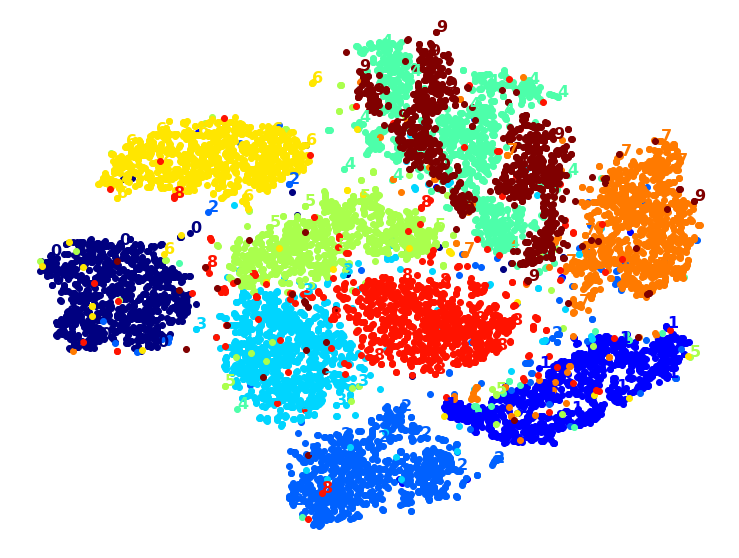

In [ ]:
from sklearn.manifold import TSNE

t0 = time.time()
X_tsne_reduced = TSNE(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 훈련 시간: {:.1f}s.".format(t1 - t0))
plot_digits(X_tsne_reduced, y)
plt.show()

**t-SNE 차원 축소 그래프**
 - ``X_test``, ``y_test`` 기준

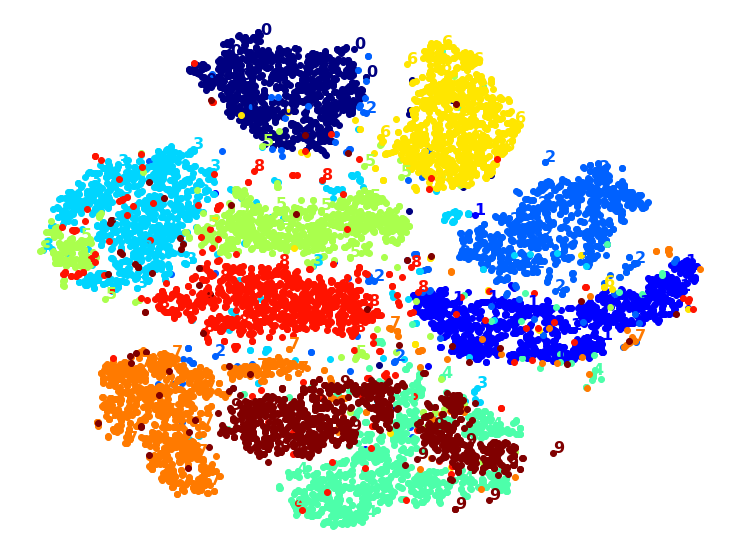

In [ ]:
X_tsne_test = TSNE(n_components=2, random_state=42).fit_transform(X_test)
plot_digits(X_tsne_test, y_test)
plt.show()

#### **2.1.2. PCA**

**PCA 차원 축소 그래프**
 - ``X``, ``y`` 기준

PCA 훈련 시간 0.9s.


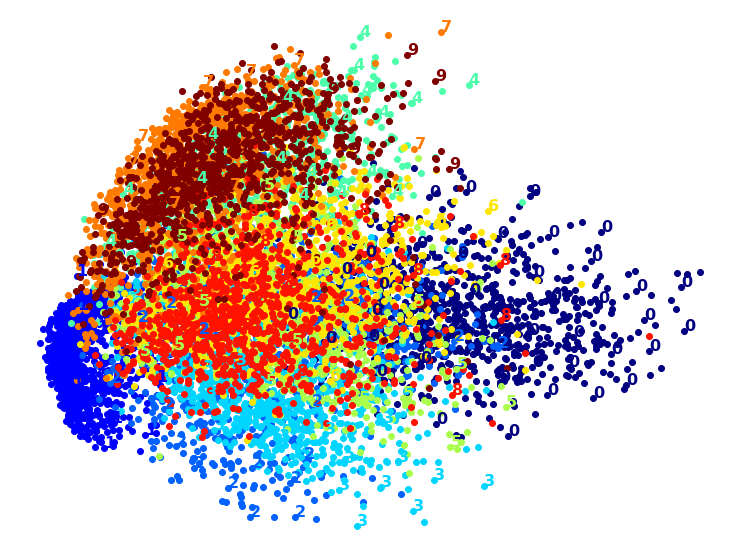

In [ ]:
from sklearn.decomposition import PCA
import time

t0 = time.time()
X_pca_reduced = PCA(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 훈련 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_pca_reduced, y)
plt.show()

**PCA 차원 축소 그래프**
 - ``X_test``, ``y_test`` 기준

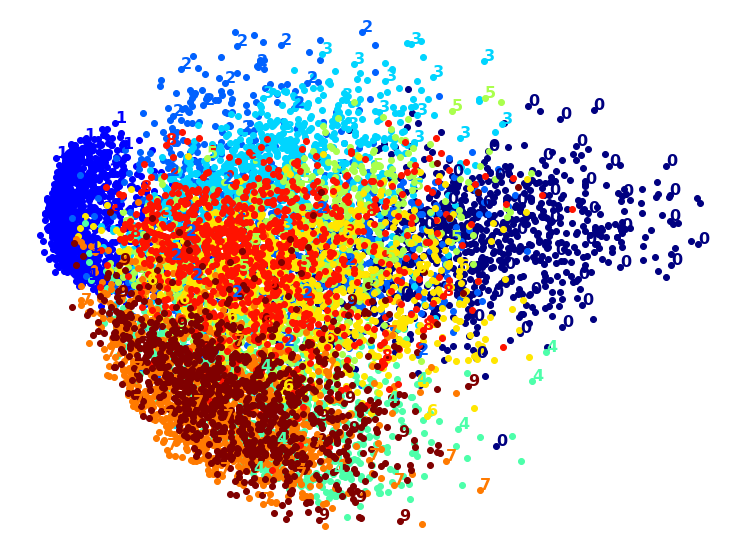

In [ ]:
X_pca_test = PCA(n_components=2, random_state=42).fit_transform(X_test)
plot_digits(X_pca_test, y_test)
plt.show()

#### **2.1.3. LLE**

**LLE 차원 축소 그래프**
 - ``X``, ``y`` 기준

LLE 훈련 시간 195.7s.


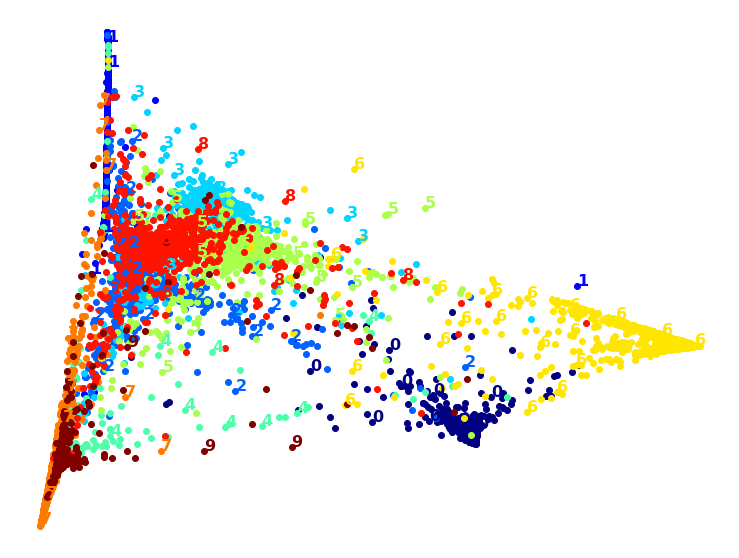

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X_lle_reduced = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 훈련 시간 {:.1f}s.".format(t1 - t0))
plot_digits(X_lle_reduced, y)
plt.show()

**LLE 차원 축소 그래프**
 - ``X_test``, ``y_test`` 기준

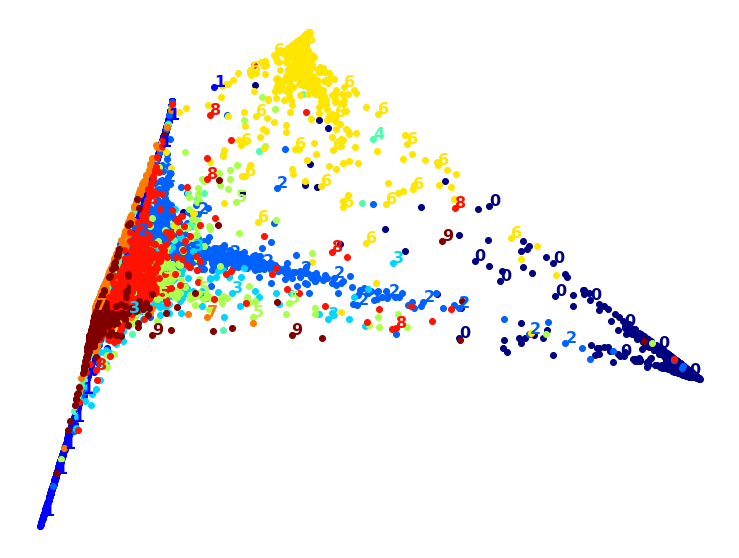

In [ ]:
X_lle_test = LocallyLinearEmbedding(n_components=2, random_state=42).fit_transform(X_test)
plot_digits(X_lle_test, y_test)
plt.show()

#### **2.1.4. MDS**

**MDS 차원 축소 그래프**
 - ``X``, ``y`` 기준
 - 다른 차원축소보다 시간이 오래걸리기 때문에 ``m = 1,000`` 기준으로 실행

MDS 훈련 시간 37.4s


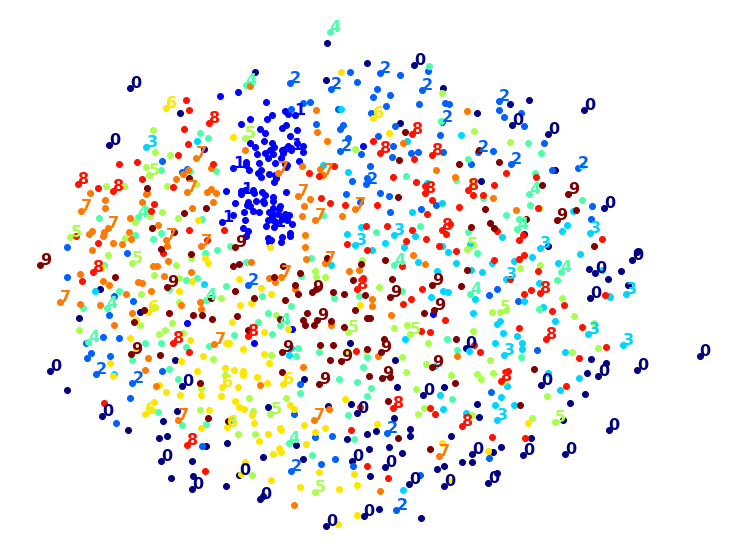

In [ ]:
from sklearn.manifold import MDS

m = 1000
t0 = time.time()
X_mds_reduced = MDS(n_components=2, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 훈련 시간 {:.1f}s".format(t1 - t0))
plot_digits(X_mds_reduced, y[:m])
plt.show()

**MDS 차원 축소 그래프**
 - ``X_test``, ``y_test`` 기준
 - 다른 차원축소보다 시간이 오래걸리기 때문에 ``m = 1,000`` 기준으로 실행

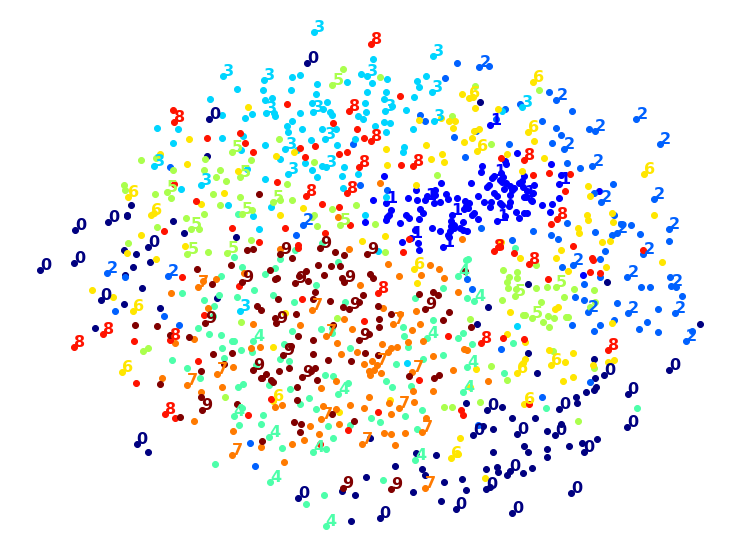

In [ ]:
X_mds_test = MDS(n_components=2, random_state=42).fit_transform(X_test[:m])
plot_digits(X_mds_test, y_test[:m])
plt.show()

### **2.2. 2차원 변환 데이터셋 - 랜덤포레스트, SVC 분류기 학습 및 성능 평가**

**변환 데이터셋 - 랜덤 포레스트 모델 훈련 및 정확성 평가**

In [ ]:
# 랜덤 포레스트 평가
rnd_clf2 = RandomForestClassifier(n_estimators=100,random_state=42)

# t-SNE
rnd_clf2.fit(X_tsne_reduced, y)
y_pred = rnd_clf2.predict(X_tsne_test)
acsc_tsne = accuracy_score(y_test, y_pred)

# PCA
rnd_clf2.fit(X_pca_reduced, y)
y_pred = rnd_clf2.predict(X_pca_test)
acsc_pca = accuracy_score(y_test, y_pred)

# LLE
rnd_clf2.fit(X_lle_reduced, y)
y_pred = rnd_clf2.predict(X_lle_test)
acsc_lle = accuracy_score(y_test, y_pred)

# MDS
rnd_clf2.fit(X_mds_reduced, y[:m])
y_pred = rnd_clf2.predict(X_mds_test)
acsc_mds = accuracy_score(y_test[:m], y_pred)

print(acsc_tsne, acsc_pca, acsc_lle, acsc_mds)

0.1298 0.1198 0.3171 0.145


정확성 평가 값이 그렇게 높게 나오진 않는다.

**변환 데이터셋 - SVC 분류기 훈련 및 정확성 평가**

In [ ]:
# SVC 분류기 평가
from sklearn.svm import LinearSVC
svc_clf2 = LinearSVC(C=1, random_state=42)

# t-SNE
svc_clf2.fit(X_tsne_reduced, y)
y_pred = svc_clf2.predict(X_tsne_test)
acsc2_tsne = accuracy_score(y_test, y_pred)

# PCA
svc_clf2.fit(X_pca_reduced, y)
y_pred = svc_clf2.predict(X_pca_test)
acsc2_pca = accuracy_score(y_test, y_pred)

# LLE
svc_clf2.fit(X_lle_reduced, y)
y_pred = svc_clf2.predict(X_lle_test)
acsc2_lle = accuracy_score(y_test, y_pred)

# MDS
svc_clf2.fit(X_mds_reduced, y[:m])
y_pred = svc_clf2.predict(X_mds_test)
acsc2_mds = accuracy_score(y_test[:m], y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print(acsc2_tsne, acsc2_pca, acsc2_lle, acsc2_mds)

0.1438 0.1015 0.1739 0.11


정확성 평가 값이 그렇게 높게 나오진 않는다.

### **2.3. t-SNE, PCA, LLE, MDS 차원축소 알고리즘 적용 -  3차원 데이터셋 변환**

 - 데이터셋 설정은 위의 2차원 변환에서 이미 불러왔다.

#### **2.3.1. t-SNE**

t-SNE 훈련 시간: 614.0s.


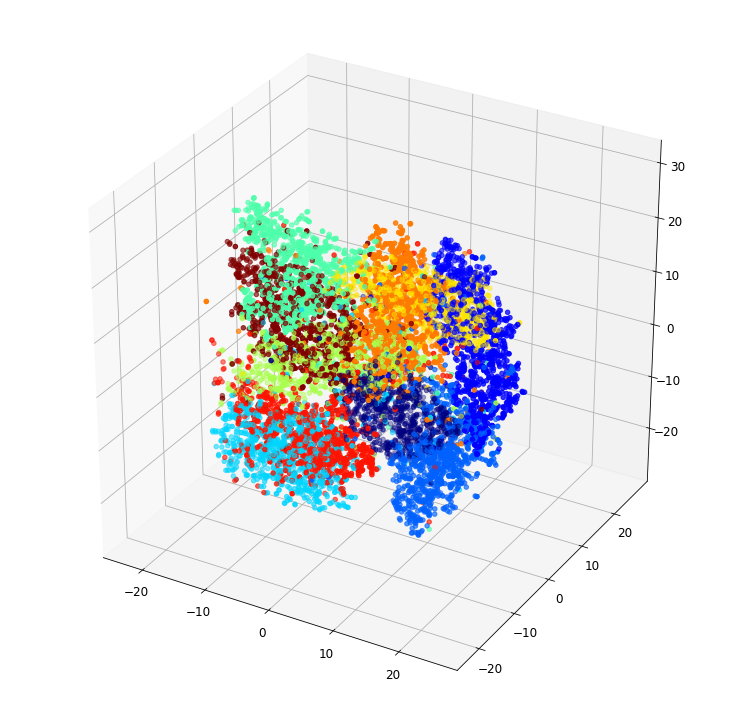

In [ ]:
from sklearn.manifold import TSNE

t0 = time.time()
X3_tsne_reduced = TSNE(n_components=3, random_state=42).fit_transform(X)
t1 = time.time()
print("t-SNE 훈련 시간: {:.1f}s.".format(t1 - t0))

plt.rcParams["figure.figsize"] = (13, 13)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3_tsne_reduced[:, 0],X3_tsne_reduced[:, 1],X3_tsne_reduced[:, 2], c=y, cmap='jet' )
plt.show()

#### **2.3.2. PCA**

PCA 훈련 시간 1.0s.


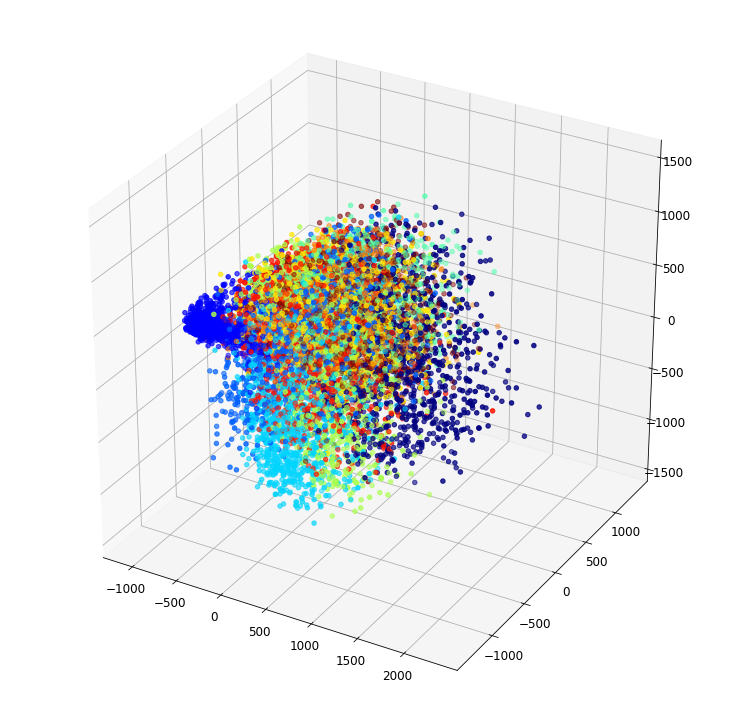

In [ ]:
from sklearn.decomposition import PCA
import time
from mpl_toolkits.mplot3d import Axes3D

t0 = time.time()
X3_pca_reduced = PCA(n_components=3, random_state=42).fit_transform(X)
t1 = time.time()
print("PCA 훈련 시간 {:.1f}s.".format(t1 - t0))

plt.rcParams["figure.figsize"] = (13, 13)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3_pca_reduced[:, 0],X3_pca_reduced[:, 1],X3_pca_reduced[:, 2], c=y, cmap='jet' )
plt.show()

#### **2.3.3. LLE**

LLE 훈련 시간 194.3s.


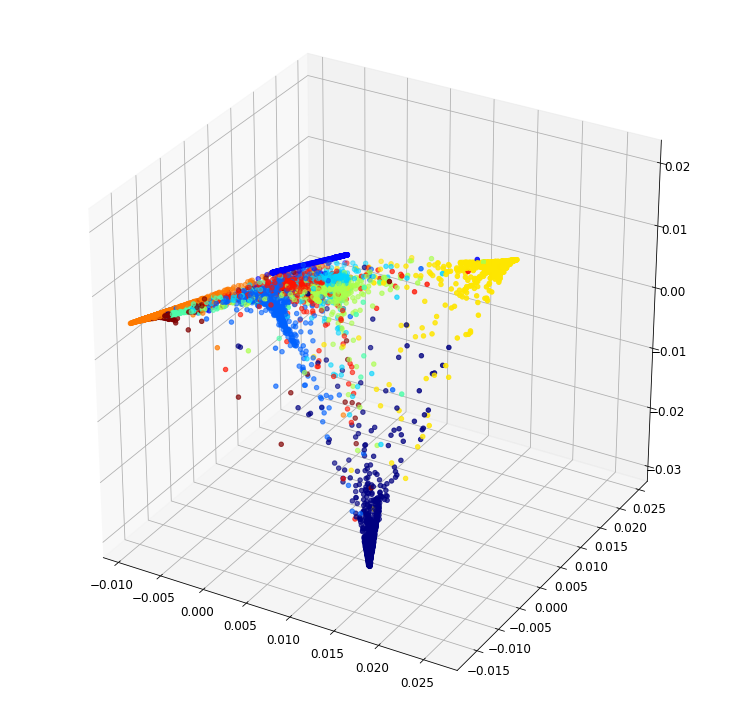

In [ ]:
from sklearn.manifold import LocallyLinearEmbedding

t0 = time.time()
X3_lle_reduced = LocallyLinearEmbedding(n_components=3, random_state=42).fit_transform(X)
t1 = time.time()
print("LLE 훈련 시간 {:.1f}s.".format(t1 - t0))

plt.rcParams["figure.figsize"] = (13, 13)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3_lle_reduced[:, 0],X3_lle_reduced[:, 1],X3_lle_reduced[:, 2], c=y, cmap='jet' )
plt.show()

#### **2.3.4. MDS**

MDS 훈련 시간 35.3s


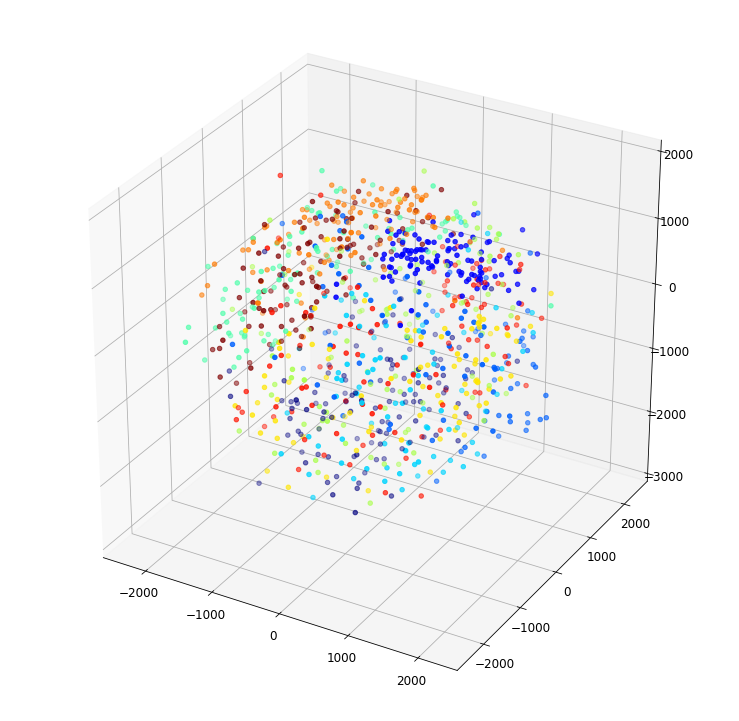

In [ ]:
from sklearn.manifold import MDS

m = 1000
t0 = time.time()
X3_mds_reduced = MDS(n_components=3, random_state=42).fit_transform(X[:m])
t1 = time.time()
print("MDS 훈련 시간 {:.1f}s".format(t1 - t0))

plt.rcParams["figure.figsize"] = (13, 13)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X3_mds_reduced[:, 0],X3_mds_reduced[:, 1],X3_mds_reduced[:, 2], c=y[:m], cmap='jet' )
plt.show()

### **2.4. 3차원 변환 데이터셋 - 랜덤포레스트, SVC 분류기 학습 및 성능 평가**

**변환 데이터셋 - 랜덤 포레스트 모델 훈련 및 정확성 평가**

In [ ]:
# 랜덤 포레스트 평가
rnd_clf3 = RandomForestClassifier(n_estimators=100,random_state=42)

X3_tsne_test = PCA(n_components=3, random_state=42).fit_transform(X_test)
X3_pca_test = PCA(n_components=3, random_state=42).fit_transform(X_test)
X3_lle_test = PCA(n_components=3, random_state=42).fit_transform(X_test)
X3_mds_test = PCA(n_components=3, random_state=42).fit_transform(X_test[:m])

In [ ]:
# t-SNE
rnd_clf3.fit(X3_tsne_reduced, y)
y_pred = rnd_clf3.predict(X3_tsne_test)
acsc_tsne3 = accuracy_score(y_test, y_pred)

# PCA
rnd_clf3.fit(X3_pca_reduced, y)
y_pred = rnd_clf3.predict(X3_pca_test)
acsc_pca3 = accuracy_score(y_test, y_pred)

# LLE
rnd_clf3.fit(X3_lle_reduced, y)
y_pred = rnd_clf3.predict(X3_lle_test)
acsc_lle3 = accuracy_score(y_test, y_pred)

# MDS
rnd_clf3.fit(X3_mds_reduced, y[:m])
y_pred = rnd_clf3.predict(X3_mds_test)
acsc_mds3 = accuracy_score(y_test[:m], y_pred)

print(acsc_tsne3, acsc_pca3, acsc_lle3, acsc_mds3)

0.0855 0.1415 0.1594 0.126


정확성 평가 값이 그렇게 높게 나오진 않는다.

**변환 데이터셋 - SVC 분류기 훈련 및 정확성 평가**

In [ ]:
# SVC 분류기 평가
from sklearn.svm import LinearSVC
svc_clf3 = LinearSVC(C=1, random_state=42)

# t-SNE
svc_clf3.fit(X3_tsne_reduced, y)
y_pred = svc_clf3.predict(X3_tsne_test)
acsc2_tsne3 = accuracy_score(y_test, y_pred)

# PCA
svc_clf3.fit(X3_pca_reduced, y)
y_pred = svc_clf3.predict(X3_pca_test)
acsc2_pca3 = accuracy_score(y_test, y_pred)

# LLE
svc_clf3.fit(X3_lle_reduced, y)
y_pred = svc_clf3.predict(X3_lle_test)
acsc2_lle3 = accuracy_score(y_test, y_pred)

# MDS
svc_clf3.fit(X3_mds_reduced, y[:m])
y_pred = svc_clf3.predict(X3_mds_test)
acsc2_mds3 = accuracy_score(y_test[:m], y_pred)

/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [ ]:
print(acsc2_tsne3, acsc2_pca3, acsc2_lle3, acsc2_mds3)

0.0611 0.1115 0.2475 0.198


정확성 평가 값이 그렇게 높게 나오진 않는다.

### **2.5. 2차원, 3차원 데이터셋 성능 평가 비교**

**2차원 변환 데이터셋**

    -       t-SNE    PCA    LLE   MDS
    - rnd: 0.1298 0.1198 0.3171 0.145
    - svc: 0.1438 0.1015 0.1739 0.110

**3차원 변환 데이터셋**

    -       t-SNE    PCA    LLE   MDS
    - rnd: 0.0855 0.1415 0.1594 0.126
    - svc: 0.0611 0.1115 0.2475 0.198

**2차원 변환 데이터셋**
 - 2차원 변환 데이터셋에서 LLE 모델이 성능 평가 시 가장 좋은 성능을 보여주었다.
 - t-SNE 차원축소 데이터를 제외하고 랜덤포레스트보다 SVC가 비교적 성능이 좋지 않았다.


 **3차원 변환 데이터셋**
 - 3차원 변환 데이터셋에서도 LLE 모델이 성능 평가 시 가장 좋은 성능을 보여주었다.
 - 성능 평가를 비교하였을 때 t-SNE, PCA는 랜덤포레스트가 LLE, MDS는 SVC가 성능 평가가 좋게 나왔다.


  **2차원과 3차원 변환 데이터셋 비교**
 - PCA는 3차원 데이터가 평가 시 성능이 좋게 나왔다. 반대로 t-SNE는 2차원 데이터가 평가 시 성능이 좋았다.
 - LLE와 MDS는 특이하게도 랜덤포레스트는 2차원이 SVC는 3차원 데이터셋이 성능이 좋게 나왔다.